In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to C:\Users\Intern02\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"The film looks super on paper. A romantic comedy in which a frantic lover gets dragged into a smuggling thriller should be generic cross-breeding gold, especially with this excellent romcomic cast.<br /><br />I'm afraid Lawrence Kasdan simply gives his two stars too much rope though and they duly go and hang themselves. Adam Brooks' script may well be to blame but you'd expect better from the Kevin Kline of A Fish Called Wanda. Instead the two ping-pong off one another and the unlikely burgeoning romance is never reconciled satisfactorily with the reason either of them are in and dashing around France.<br /><br />Jean Reno co-stars amiably as the cop-with-a-heart and I guess wishes he was a star-with-a-part. Mind you he went on to do those Pink Panther remake(s!) so perhaps he was OK with this... 3/10"
 b"After all these years I still consider this series the finest example of World War II documentary film making. The interviews with the many participants from all countries 

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,  20, 263, ...,   0,   0,   0],
       [101,  32, 128, ...,   0,   0,   0],
       [ 50, 349, 175, ...,   0,   0,   0]], dtype=int64)

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The film looks super on paper. A romantic comedy in which a frantic lover gets dragged into a smuggling thriller should be generic cross-breeding gold, especially with this excellent romcomic cast.<br /><br />I'm afraid Lawrence Kasdan simply gives his two stars too much rope though and they duly go and hang themselves. Adam Brooks' script may well be to blame but you'd expect better from the Kevin Kline of A Fish Called Wanda. Instead the two ping-pong off one another and the unlikely burgeoning romance is never reconciled satisfactorily with the reason either of them are in and dashing around France.<br /><br />Jean Reno co-stars amiably as the cop-with-a-heart and I guess wishes he was a star-with-a-part. Mind you he went on to do those Pink Panther remake(s!) so perhaps he was OK with this... 3/10"
Round-trip:  the film looks [UNK] on [UNK] a romantic comedy in which a [UNK] [UNK] gets [UNK] into a [UNK] thriller should be [UNK] [UNK] [UNK] especially with this excelle

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00528494]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00528494]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 602s 2s/step - loss: 0.6328 - accuracy: 0.5821 - val_loss: 0.4822 - val_accuracy: 0.7599
Epoch 2/10
391/391 [==============================] - 678s 2s/step - loss: 0.4305 - accuracy: 0.7956 - val_loss: 0.3852 - val_accuracy: 0.8344
Epoch 3/10
391/391 [==============================] - 639s 2s/step - loss: 0.3540 - accuracy: 0.8429 - val_loss: 0.3496 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 655s 2s/step - loss: 0.3405 - accuracy: 0.8530 - val_loss: 0.3352 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 665s 2s/step - loss: 0.3180 - accuracy: 0.8652 - val_loss: 0.3317 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 629s 2s/step - loss: 0.3123 - accuracy: 0.8682 - val_loss: 0.3317 - val_accuracy: 0.8479
Epoch 7/10
391/391 [==============================] - 582s 1s/step - loss: 0.3049 - accuracy: 0.8720 - val_loss: 0.3223 - val_accuracy: 0.8557

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 96s 245ms/step - loss: 0.3266 - accuracy: 0.8462
Test Loss: 0.3265545070171356
Test Accuracy: 0.8462399840354919


(0.0, 0.6495973557233811)

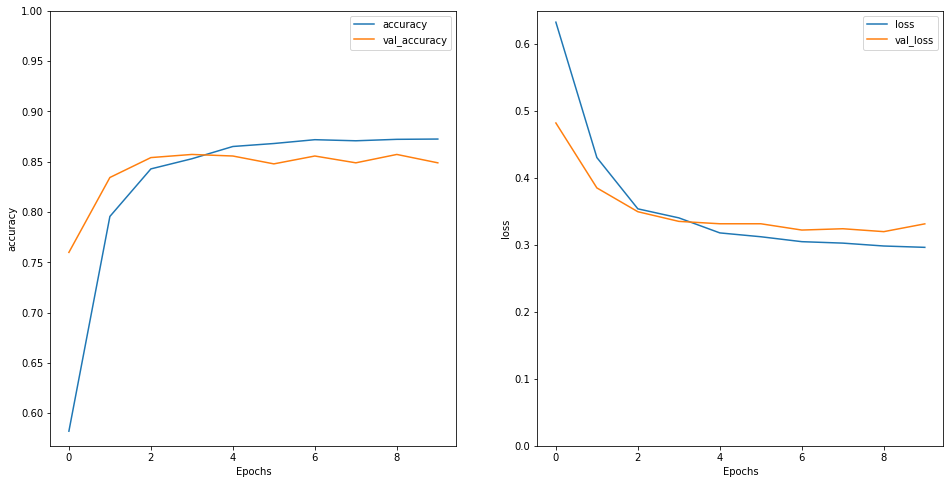

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.69483906]]


In [22]:
sample_text = ('The movie sucks. The animation and the graphics '
               'were really bad. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.2922969]]


Stack two or more LSTM layers

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1083s 3s/step - loss: 0.6366 - accuracy: 0.5764 - val_loss: 0.4551 - val_accuracy: 0.7859
Epoch 2/10
391/391 [==============================] - 1058s 3s/step - loss: 0.4052 - accuracy: 0.8214 - val_loss: 0.3623 - val_accuracy: 0.8385
Epoch 3/10
391/391 [==============================] - 1165s 3s/step - loss: 0.3446 - accuracy: 0.8526 - val_loss: 0.3295 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 1146s 3s/step - loss: 0.3249 - accuracy: 0.8632 - val_loss: 0.3280 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 1125s 3s/step - loss: 0.3148 - accuracy: 0.8649 - val_loss: 0.3281 - val_accuracy: 0.8484
Epoch 6/10
391/391 [==============================] - 1128s 3s/step - loss: 0.3103 - accuracy: 0.8676 - val_loss: 0.3147 - val_accuracy: 0.8583
Epoch 7/10
203/391 [==============>...............] - ETA: 8:40 - loss: 0.3004 - accuracy: 0.8741

KeyboardInterrupt: 